In [139]:
import torch
from torch import nn
from torch.utils.data import Dataset , DataLoader
import pandas as pd
import numpy as np
import pickle
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [140]:
df = pd.read_pickle('cleaned_data.pkl')

In [141]:
df.head(2)

,mel,label
0,<PIL.Image.Image image mode=RGB size=224x244 a...,Pop
1,<PIL.Image.Image image mode=RGB size=224x244 a...,Pop


In [142]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [143]:
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])

LabelEncoder()

In [144]:
X_train,X_temp,Y_train,Y_Temp = train_test_split(df['mel'],df['label'],test_size=.3,stratify=df['label'])
X_val,X_test,Y_val,Y_test = train_test_split(X_temp,Y_Temp,train_size=.5,stratify=Y_Temp)

In [145]:
X_train.shape,X_val.shape,Y_test.shape

((21069,), (4515,), (4515,))

In [146]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomAffine(degrees=0,translate=(.1,0)),
    transforms.ColorJitter(brightness=.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])

In [147]:
class CustomDataset(Dataset):
    def __init__(self,x,y,transofmr=None):
        super().__init__()
        self.X = x
        self.Y= torch.as_tensor(label_encoder.transform(y.values).astype(int),dtype=torch.long)
        self.transform = transofmr

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image = self.X.iloc[index]
        label =self.Y[index]

        if self.transform:
            image = self.transform(image)

        return image,label


In [148]:
train_dataset = CustomDataset(X_train,Y_train,transofmr=train_transforms)
val_dataset = CustomDataset(X_val,Y_val,transofmr=val_transforms)
test_dataset = CustomDataset(X_test,Y_test,transofmr=val_transforms)

In [161]:
BATCH_SIZE = 128
LR = 3e-4
EPOCH = 10

In [162]:
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

<Figure size 400x400 with 0 Axes>

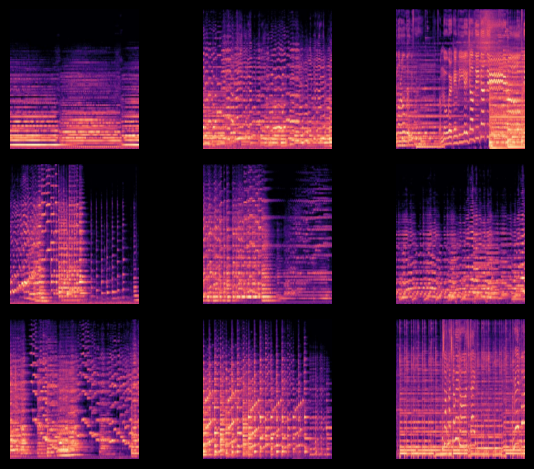

In [163]:
n_col = 3
n_row =3 
plt.figure(figsize=(4,4))
f,axis=plt.subplots(3,3)
for r in range(n_row):
    for c in range(n_col):
        image = X_train.sample(1).item()
        axis[r,c].imshow(image)
        axis[r,c].axis('off')
        plt.style.use('dark_background')
plt.tight_layout()

In [164]:
for x in X_train:
    print(x.size)
    break

(224, 244)


In [165]:
class MyModule(nn.Module):
    def __init__(self,num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.classifer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*28*28,128),
            nn.ReLU(),
            nn.Dropout(.3),
            nn.Linear(128,num_classes)
            )

    def forward(self,x):
        x = self.features(x)
        x=self.classifer(x)
        return x

In [166]:
num_classes= df.label.nunique()

In [167]:
model =MyModule(num_classes).to(device)

In [168]:
optimizer  =torch.optim.Adam(model.parameters(),lr=LR,weight_decay=1e-4)
critertion = nn.CrossEntropyLoss()

In [169]:
total_train_loss_plot = []
total_train_acc_plot = []
total_val_loss_plot = []
total_val_acc_plot = []
best_val_acc =0

In [170]:
for x,y in train_dataloader:    
    print(x.shape,y.shape)
    break

torch.Size([128, 1, 224, 224]) torch.Size([128])


In [171]:
for epoch in range(EPOCH):
    model.train()
    total_train_acc =0
    total_train_loss = 0
    total_val_acc = 0
    total_val_loss = 0
    for image,label in tqdm(train_dataloader,desc='Training'):
        image,label=image.to(device),label.to(device)

        optimizer.zero_grad()
        output = model(image)
        train_loss=critertion(output,label)
        train_loss.backward()
        optimizer.step()

        total_train_loss+=train_loss.item()*image.size(0)
        preds = torch.argmax(output,dim=1)
        total_train_acc += (preds==label).sum().item()

    total_train_loss_plot.append(round(total_train_loss/len(train_dataset),4))
    total_train_acc_plot.append(round(total_train_acc/len(train_dataset)*100,4))
    
    model.eval()
    with torch.no_grad():
        for image,label in val_dataloader:
            image,label=image.to(device),label.to(device)

            output = model(image)
            val_loss = critertion(output,label)
            
            total_val_loss +=val_loss.item() * image.size(0)
            preds = torch.argmax(output,dim=1)
            total_val_acc += (preds==label).sum().item()

    total_val_acc_plot.append(round(total_val_acc/len(val_dataset)*100,4))
    total_val_loss_plot.append(round(total_val_loss/len(val_dataset),4))

    print(f'Epoch/{epoch} Train Loss : {total_train_loss_plot[epoch]} Train Acc: {total_train_acc_plot[epoch]}%')
    print(f'Epoch/{epoch} Val Loss : {total_val_loss_plot[epoch]} Val Acc: {total_val_acc_plot[epoch]}%')

    if total_val_acc/len(val_dataset)> best_val_acc:
        best_val_acc = total_val_acc/len(val_dataset)
        torch.save(model.state_dict(),'best_model_butteryfly.pth')
        print(f'Model saved with val acc:{round(total_val_acc/len(val_dataset)*100,2)}%')

Training: 100%|██████████| 165/165 [02:36<00:00,  1.06it/s]


Epoch/0 Train Loss : 1.9956 Train Acc: 37.0165%
Epoch/0 Val Loss : 1.3253 Val Acc: 56.7663%
Model saved with val acc:56.77%


Training: 100%|██████████| 165/165 [02:41<00:00,  1.02it/s]


Epoch/1 Train Loss : 1.4382 Train Acc: 51.8155%
Epoch/1 Val Loss : 1.1966 Val Acc: 61.7054%
Model saved with val acc:61.71%


Training: 100%|██████████| 165/165 [02:36<00:00,  1.05it/s]


Epoch/2 Train Loss : 1.3256 Train Acc: 56.2817%
Epoch/2 Val Loss : 1.0988 Val Acc: 63.9646%
Model saved with val acc:63.96%


Training: 100%|██████████| 165/165 [02:49<00:00,  1.03s/it]


Epoch/3 Train Loss : 1.2273 Train Acc: 59.9364%
Epoch/3 Val Loss : 1.0419 Val Acc: 67.3976%
Model saved with val acc:67.4%


Training: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


Epoch/4 Train Loss : 1.174 Train Acc: 61.6878%
Epoch/4 Val Loss : 1.0018 Val Acc: 68.4607%
Model saved with val acc:68.46%


Training: 100%|██████████| 165/165 [02:35<00:00,  1.06it/s]


Epoch/5 Train Loss : 1.1279 Train Acc: 63.2446%
Epoch/5 Val Loss : 0.9342 Val Acc: 72.2259%
Model saved with val acc:72.23%


Training: 100%|██████████| 165/165 [02:29<00:00,  1.10it/s]


Epoch/6 Train Loss : 1.0875 Train Acc: 64.8441%
Epoch/6 Val Loss : 0.9175 Val Acc: 71.6279%


Training: 100%|██████████| 165/165 [03:02<00:00,  1.10s/it]


Epoch/7 Train Loss : 1.0592 Train Acc: 65.9357%
Epoch/7 Val Loss : 0.9487 Val Acc: 69.5903%


Training: 100%|██████████| 165/165 [03:07<00:00,  1.14s/it]


Epoch/8 Train Loss : 1.0339 Train Acc: 66.7426%
Epoch/8 Val Loss : 0.9067 Val Acc: 72.381%
Model saved with val acc:72.38%


Training: 100%|██████████| 165/165 [03:08<00:00,  1.14s/it]


Epoch/9 Train Loss : 1.0058 Train Acc: 67.2694%
Epoch/9 Val Loss : 0.8744 Val Acc: 74.773%
Model saved with val acc:74.77%
